# Grover's Algorithm and Matched Filtering

Here we will consider trying to find the frequency of a sine wave signal from amongst a number of known frequencies when the signal start time and amplitudes are known. Time domain data $\mathcal{D}$ of length $N$ is taken from the signal and compared to $M$ templates $\mathcal{T}$ of sine waves of known frequencies equally spaced out in the frequency space of interest. The signals are discretized with a precision dependent on $F$. The number of times Grover's algorithm is applied is dependent on $P$.



In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt

from functools import partial

from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter, make_frequency_series
from pycbc.types import TimeSeries, FrequencySeries

import time, os, h5py, multiprocessing

debug = False

# Set the random number generator seed 
np.random.seed(int(time.time()))

In [2]:
SNR = 12.
Data = np.load('signal.npy')
psd = np.load('psd.npy')

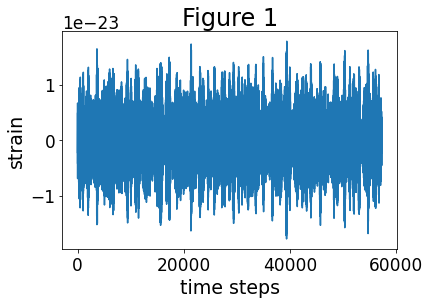

In [3]:
plt.plot(np.fft.irfft(Data))
plt.title('Figure 1')
plt.xlabel('time steps')
plt.ylabel('strain')
plt.show()

In [4]:
# Qubits for templates
Mqubits = 9
# Qubits for Grover's
Pqubits = 7

In [5]:
# N is the number of data points
N = len(Data)
# Number of templates
M = int(2**(Mqubits))
# Number of states in ancillary register
P = int(2**(Pqubits))

In [6]:
# Generate indicies over time
n_inds = np.arange(N)
# Generate indicies over templates
m_inds = np.arange(M)
# Create indicies for each Grover's iteration
p_inds = np.arange(P)

The signal sine wave signal looks like:

First let us make the state:

$$ |\psi_{\text{ini}}⟩ = \frac{1}{\sqrt{M}}\sum^{M-1}_{m=0}|m⟩. $$

In [7]:
# Initiating the joint states across float, time and template qubits
initial_states = np.ones((M))/np.sqrt(M)

In [8]:
def SNR_given_index(data, psd, dt, df, paras):
    m1,m2,s1,s2,fl = paras
    N = len(data)
    waveform_ = get_td_waveform(approximant="IMRPhenomPv3",
                                mass1=m1, mass2=m2,
                                spin1z=s1, spin2z=s2,
                                delta_t=dt, f_lower=fl)
    waveform_[0].resize(int(2*(N - 1)))
    template_ = waveform_[0].cyclic_time_shift(waveform_[0].start_time)
    template = np.array(make_frequency_series(TimeSeries(template_,delta_t=dt)))
    SNR = matched_filter(FrequencySeries(template, delta_f=df),
                FrequencySeries(data, delta_f=df),
                FrequencySeries(psd, delta_f=df))
    SNR = np.array(SNR.crop(8, 4))
    return np.max(np.abs(SNR))

In [9]:
def get_paras(initial_states):
    '''
    Get mass/spins from index
    ''' 
    M = initial_states.shape[0]
    bank_file = 'H1L1-BANK2HDF_SPLITBANK_BANK0_INJECTIONS-1134450017-1202400.hdf'
    full_bank = h5py.File(bank_file,'r')

    bank_size = full_bank['mass1'].size
    
    indexes = np.arange(bank_size)[::int(bank_size//M)][:-1]
    
    bank = {}
    bank['mass1'] = full_bank['mass1'][indexes]    
    bank['mass2'] = full_bank['mass2'][indexes] 
    bank['spin1z'] = full_bank['spin1z'][indexes] 
    bank['spin2z'] = full_bank['spin2z'][indexes]    

    return bank

In [37]:
def k_12(initial_states, Data, dt=1./2048, f_low=20., threshold=12):
    '''
    Make wavforms from index
    ''' 
    M = initial_states.shape[0]
    N = len(Data)
    bank_file = 'H1L1-BANK2HDF_SPLITBANK_BANK0_INJECTIONS-1134450017-1202400.hdf'
    full_bank = h5py.File(bank_file,'r')
    
    bank_size = full_bank['mass1'].size
    print(bank_size)
    
    psd = np.load('psd.npy')
    freqs = np.fft.fftfreq(2*(N-1))*1./dt
    df = np.abs(freqs[1]-freqs[0])

    if bank_size>M:
        indexes = np.arange(bank_size)[::int(bank_size//M)][:M]
    else:
        indexes = np.arange(bank_size)
        
    m1s = full_bank['mass1'][indexes]
    m2s = full_bank['mass2'][indexes]
    s1s = full_bank['spin1z'][indexes]
    s2s = full_bank['spin2z'][indexes]    
    fls = full_bank['f_lower'][indexes]

    paras = iter(np.array([m1s,m2s,s1s,s2s,fls]).T)
    
    pool = multiprocessing.Pool(multiprocessing.cpu_count())
    func = partial(SNR_given_index, Data, psd, dt, df)
    SNRs = np.array(pool.map(func, paras))
    pool.close()
    w = np.where(SNRs>=threshold,-1.,1.)

    if len(w)<M:
        w = np.pad(w,(0,M-len(w)),constant_values=1.).astype(float)
    w*=1./np.sqrt(M)
    return w

$|w⟩$ is made by applying $\hat{k}_{2}$ to $|T⟩\otimes|D⟩$:

$$|w⟩ = \hat{k}_{2}(|T⟩\otimes|D⟩).$$

In [38]:
# Compare the templates to the data to get states w
w = k_12(initial_states, Data, threshold=SNR)

49994


In [12]:
print(w)

[ 0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417  0.04419417
  0.04419417  0.04419417  0.04419417  0.04419417  0

Then we make the state:

$$ |\psi_{0}⟩ = \frac{1}{\sqrt{PM}}\sum^{P-1}_{p=0}\sum^{M-1}_{m=0}|p⟩|m⟩. $$

This is equivalent of the state $|s⟩$ previously made, but $P$ times.

In [13]:
# Initialising joint state psi_0 which we apply Grover's algorithm over given w
psi_0 = np.ones((M,P))/np.sqrt(M*P)

The first part of Grover's algorithm is then applied as follows:

1. Create operator $\hat{U}_{w}=\mathcal{I}-2|w⟩⟨w|$ where $w$ is the matrix position corresponding to the matching templates. This operator has the property:

$$ \hat{U}_{w} |x⟩ = -|x⟩ \text{ if } x=w, $$
$$ \hat{U}_{w} |x⟩ = |x⟩ \text{ if } x\ne w.\ \ \$$

2. Initiate superposition:

$$ |s⟩ = \frac{1}{\sqrt{M}}\sum^{M-1}_{x=0}|x⟩, $$

assuming that every template is equally likely to have the correct template without any more prior knowledge.

3. Create the Grover diffusion operator $\hat{U}_{s}=2|s⟩⟨s|-\mathcal{I}$.

4. Apply $\hat{U}_{w}$ then $\hat{U}_{s}$ to $|s⟩$ $p$ times to each state in $P$ ($p=\{0,1,...P-1\}$).

In [14]:
def U_w(w):
    '''
    Defines the matrix operation applied to psi_0 given w.
    This operator flips the phase of a state that corresponds to w.
    '''
    M = len(w)
    return np.sqrt(M)*np.multiply(np.eye(M),w)

In [15]:
def U_s(w):
    '''
    Defines the matrix operation applied to psi_0 given w.
    This is "Grovers diffusion operator". 
    '''
    M = len(w)
    s_i = np.array([np.ones(M)/np.sqrt(M)]).T
    return 2*np.outer(s_i,s_i)-np.eye(M)

In [16]:
def Grovers1(w, psi_0):
    '''
    This corresponds to the first part of Grovers algorithm.
    Here operators U_w and U_s are applied to psi_0 "p" times for each of the P states.
    '''
    M, P = psi_0.shape[0], psi_0.shape[1]
    psi_1 = np.zeros((M,P))
    for p in np.arange(P):
        psi_1[:,p] = np.dot(np.linalg.matrix_power(np.matmul(U_s(w),U_w(w)),p),psi_0[:,p])
    return psi_1

Now we apply Grover's algorithm itterably to this state such that:

$$ |\psi_{1}⟩ = \hat{C}_{G}|\psi_{0}⟩, $$

where $\hat{C}_{G}|p⟩\otimes |m⟩\rightarrow |p⟩\otimes (\hat{G})^{p}|m⟩$,

and $\hat{G}=\hat{U_{s}}\hat{U_{w}}$.

In [17]:
# Apply the first part of Grover's algorithm
psi_1 = Grovers1(w,psi_0)

We can see what this operation does to $|\psi_{0}⟩$ in the plot bellow:

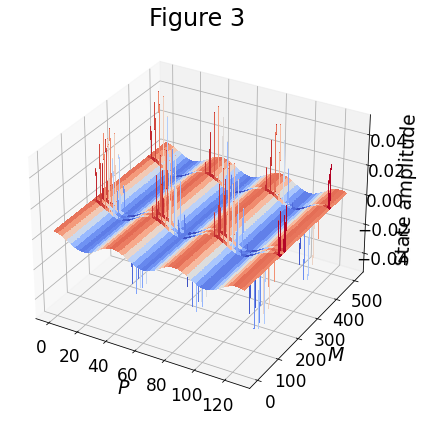

In [18]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

X, Y = np.meshgrid(p_inds, m_inds)
Z=psi_1
fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_title('Figure 3')
ax.set_xlabel(r'$P$')
ax.set_ylabel(r'$M$')
ax.set_zlabel('State amplitude')

plt.show()

We see the amplitudes of states $\psi_{1}$ numbering $P\times M$. Where the amplitudes of the states around correct solutions are much greater than the incorrect solutions. The incorrect solutions also exhibit a sinusoidal pattern. 

It is the frequency $f$ of this sinusoid that we wish to determine, as it is related to the number of correct template matches $k$ by:

$$ k = \sin^{2}\frac{f\pi}{P}. $$

Determining phase/frequency information from amplitudes of states requires a *quantum fourier transform*.

### Quantum Fourier Transform

The *quantum fourier transform* is much the same as it's classical counterpart but is performed on amplitude/phase information stored on the states of qubits. It transfers information stored in amplitudes in quantum states into phase information. There also exists the inverse quantum fourier transform for the reverse opperation.

The quantum fourier transform acting on state $|p⟩$ gives:

$$ \mathrm{QFT}:|x⟩ \mapsto \frac{1}{\sqrt{K}}\sum^{K-1}_{k=0}e^{2\pi i\frac{kx}{K}}|k⟩. $$

The inverse quantum fourier transform is applied across the ancillary qubits the recover the phase information from the sinusoidal behaviour in the states shown in the graph above. This requires creating a $QFT^{-1}$ operator of size $P\times P$, which we will call $\hat{F}_{P}$ as done below:

In [19]:
def IQFT(P):
    '''
    Constructing the inverse fourier transform of size PxP.
    '''
    return np.round(
            np.array([[(np.exp(-2.*i*j*1j*np.pi/P)) 
                   for j in np.arange(P)] 
                    for i in np.arange(P)]),1)*1./np.sqrt(P)

In [20]:
def Grovers2(psi_1):
    '''
    The seconds part of Grovers algorithm. 
    Here we apply the inverse quantum Fourier transform to psi_2.
    '''
    M, P = psi_1.shape[0], psi_1.shape[1]
    return np.dot(IQFT(P),psi_1.T)

Applying this across the ancillary states in $|\psi_{1}⟩$:

$$ \psi_{2} = \hat{F}_{P}\psi_{1}. $$

In [21]:
# We apply the second part of Grover's algoirthm to state psi_1
psi_2 = Grovers2(psi_1)

This operation changes $|\psi_{1}⟩$ to the states in the plot bellow (note that I now show the state probability and not the amplitudes in the $z$ axis): 

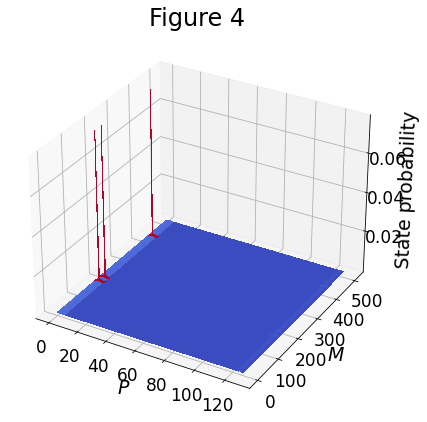

In [22]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm

X, Y = np.meshgrid(p_inds, m_inds)
Z=np.absolute(psi_2).T**2
fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_title('Figure 4')
ax.set_xlabel(r'$P$')
ax.set_ylabel(r'$M$')
ax.set_zlabel('State probability')

plt.show()

The probabilities $|\psi_{2}|^{2}$ are seen over ancillary and template states. There are two peaks, corresponing to $f$ and $P-f$. Measuring the ancillary state will likely acquire one or the other. These peaks also correspond to the positions of matching templates, and so measuring the template qubits likely recovers a correct position of a template.

From knowing $f$ or $P-f$ we can work out the number of matched templates $k$ with the relation:

$$ k = M\sin^{2}\frac{f\pi}{P}. $$

Doing this gives the number of matching templates for this example as:

In [23]:
# Measure each of the qubits corresponding to template states M and period states P
measurement = np.unravel_index(np.argmax(np.absolute(psi_2)**2), psi_2.shape)

# The resulting state measured from the P qubits tells us about the number of matching templates
P_measured = measurement[0]
print(P_measured)

3


In [24]:
# The result from measuring P corresponds to the frequency of the sinesoid shown in Figure 3
N_templates = int(np.round(M*np.sin(P_measured*np.pi/P)**2))
opt_p = int(np.round((np.pi/4.)* np.sqrt(M/N_templates)))

print('Number of matching templates:',N_templates)
print('Optimum number of Grover applications:',opt_p)

Number of matching templates: 3
Optimum number of Grover applications: 10


In [25]:
Templates = k_12(initial_states, Data, threshold=SNR)
psi_0 = np.ones((M))/np.sqrt(M)
psi_1 = np.dot(np.linalg.matrix_power(np.matmul(U_s(w),U_w(w)),opt_p),psi_0)

In [26]:
probs_out = []
for p in np.arange(2*opt_p+1):
    psi_1_ = np.dot(np.linalg.matrix_power(np.matmul(U_s(w),U_w(w)),p),psi_0)
    probs_out.append(np.max(np.abs(psi_1_)**2))

probs_out = np.array(probs_out)

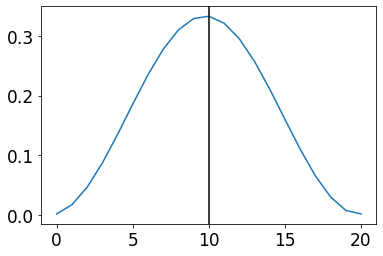

In [27]:
plt.plot(probs_out)
plt.axvline(x=opt_p, color='black')
plt.show()

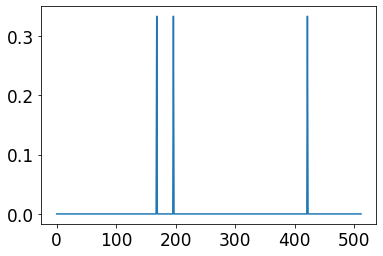

In [28]:
plt.plot(np.abs(psi_1)**2)
plt.show()

In [29]:
paras = get_paras(initial_states)

In [30]:
Data = np.load('noise.npy')
# N is the number of data points
N = len(Data)

In [31]:
# Initiating the joint states across float, time and template qubits
initial_states = np.ones((M))/np.sqrt(M)

In [32]:
w = k_12(initial_states, Data, threshold=SNR)

In [33]:
# Initialising joint state psi_0 which we apply Grover's algorithm over given w
psi_0 = np.ones((M,P))/np.sqrt(M*P)
# Apply the first part of Grover's algorithm
psi_1 = Grovers1(w,psi_0)
# We apply the second part of Grover's algoirthm to state psi_1
psi_2 = Grovers2(psi_1)

In [34]:
# Measure each of the qubits corresponding to template states M and period states P
measurement = np.unravel_index(np.argmax(np.absolute(psi_2)**2), psi_2.shape)

# The resulting state measured from the P qubits tells us about the number of matching templates
P_measured = measurement[0]

In [35]:
# The result from measuring P corresponds to the frequency of the sinesoid shown in Figure 3
N_templates = int(np.round(M*np.sin(P_measured*np.pi/P)**2))

In [36]:
print(N_templates)

0
